In [1]:
import torch
from PIL import Image
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
loaded_model = torch.load('/content/drive/MyDrive/saved_models/inception_2015_stratify.h5')
loaded_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [3]:
class ben_color(object):
   
   #     Parameters
   #    ----------
   #   img: 2D numpy array
   #         The original image with format of (h, w, c)
    
    def __call__(self, img, sigmaX=10):
        """
        :param img: PIL): Image 

        :return: Normalized image
        """

        img = np.asarray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.crop_image_from_gray(img)
        img = cv2.resize(img, (input_size, input_size))
        img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
        return Image.fromarray(img)

    def crop_image_from_gray(self, img, tol=7):
        if img.ndim ==2:
            mask = img>tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img>tol
            
            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0):
                return img 
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                img = np.stack([img1,img2,img3],axis=-1)
            return img

    def __repr__(self):
        return self.__class__.__name__+'()'

In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        ben_color(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        ben_color(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        ben_color(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")
data_dir = '/content/drive/MyDrive/data_2015_stratify'
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'test', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = 224
def predict_image(image):
    image_tensor = data_transforms['test'](image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = loaded_model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [26]:
predict_image(Image.open('/content/drive/MyDrive/data_2015_stratify/train/0/10033_left.jpg'))

1

Text(0.5, 69.0, 'Predicted label')

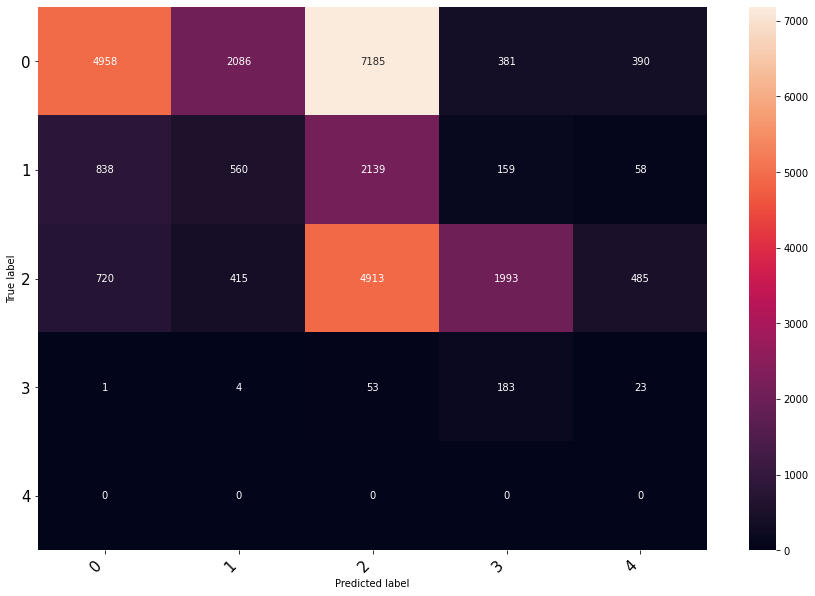

In [17]:
import pandas as pd
import seaborn as sns

nb_classes = 5
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = ['0', '1', '2', '3', '4']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
df_cm.sum().sum()

27544

In [21]:
10614/27544

0.385347081033982

Text(0.5, 69.0, 'Predicted label')

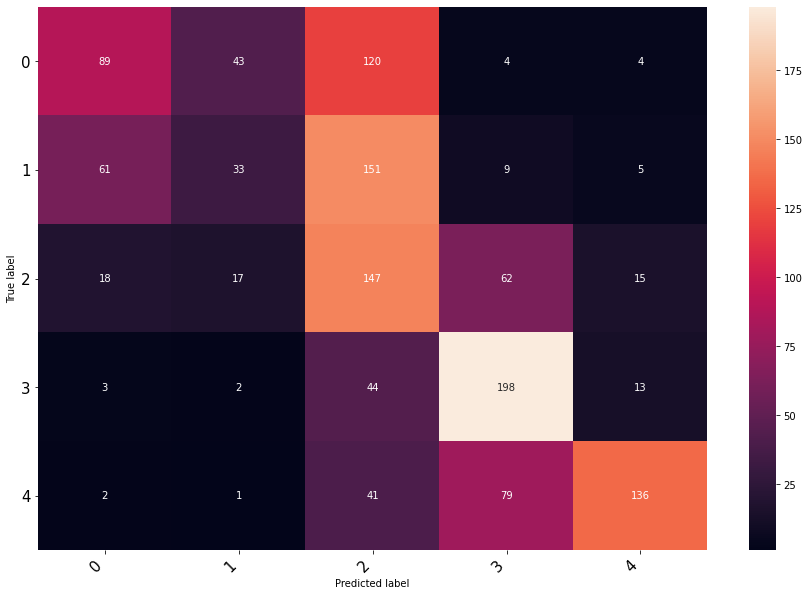

In [23]:

nb_classes = 5
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = ['0', '1', '2', '3', '4']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 69.0, 'Predicted label')

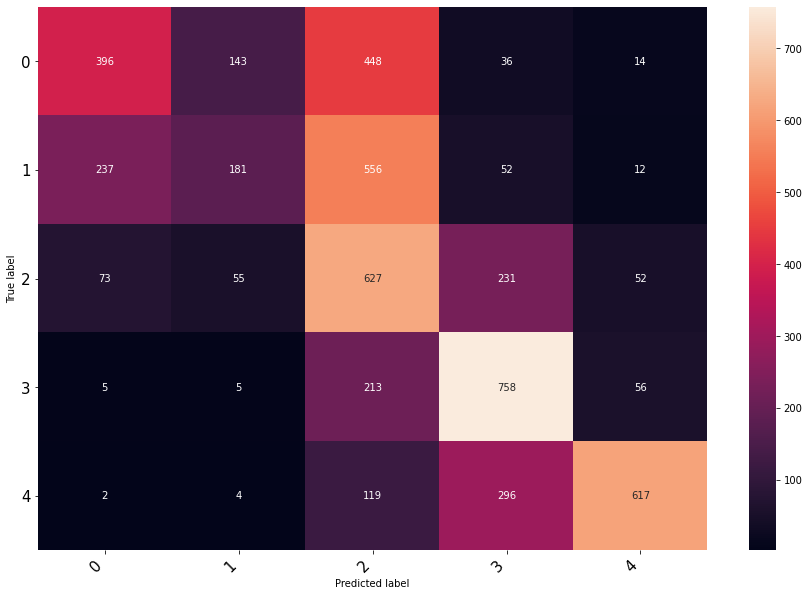

In [29]:
nb_classes = 5
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = ['0', '1', '2', '3', '4']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')